## Calculating Kicks to Semimajor Axis

In this notebook, we simulate a close encounter between planets to determine the "kicks" to the semi-major axis at conjunction. We compare this numerical result with an analytical solution as derived by Namouni et al.

### Namouni's Analytical Result
As found in Namoni et al, the effective potential between two planets can be expanded in powers of eccentricity:

\begin{align}
    W = \sum_{q = -\infty}^{\infty} W_q e^{in(\lambda-\phi)}(-1)^q
\end{align}

The following values were found as the coefficients of this expansion:

In [2]:
W1 = 3.359
W2 = 2.678665722
W3 = 2.639498803
W4 = 2.8559

The kicks to semi-major axis at conjunction can be expressed using these coefficients as follows:

\begin{align}
    \frac{\Delta a_r}{a_0} = -\frac{8}{9} \frac{\mu}{e_c^2} \sum_{q=1}^{\infty} q \tilde{e}^q \sin{(q (\lambda - \varpi))} \lvert W_q \rvert
\end{align}

### Numerical Simulation

In [3]:
# Imports
import matplotlib.pyplot as plt
import rebound
import numpy as np

#### Constants and parameters

The setup consists of two planets in an MMR. We study the Hill approximation, the limit in which the planets are closely spaced and their mass is much smaller than that of the star. In this setup, each planet travels on a slightly eccentric orbit (defined by eccentricity vectors $\vec{e}_1$ and $\vec{e}_2$, where the direction of the vector points toward the pericenter of the orbit). The relative eccentricity is $\vec{e}_{\mathrm{rel}} = \vec{e}_2 - \vec{e}_1$, where the magnitude of this vector is the relative eccentricity $\vec{e}$ and the angle of this vector (taken with respect to the direction in which where the orbits are closest together) is the relative $\varpi$.

In [5]:
j, k = 100, 1           # j:j-k MMR
mutot = 3e-12 *125      # (m1 + m2) / mstar
phi = 2*np.pi/3         # measured from where orbits are closest together

# the desired relative eccentricity, e_test
ec = 2*k/3/j            # crossing eccentricity, factor to normalize e
etilde = 0.1            # eccentricity ratio to crossing value (e/e_c)
e_test = etilde*ec      # eccentricity from outer tp case

# inner planet
mu1= mutot/2            # m1/m_star
pomega1 = -np.pi/2      # pericenter
e1 = e_test/2           # eccentricity

# outer planet
mu2= mutot-mu1          # m2/m_star
pomega2 = np.pi/2       # pericenter
e2 = e_test/2           # eccentricity

# relative coordinates
e1vec = e1*np.cos(pomega1) + 1j*e1*np.sin(pomega1)
e2vec = e2*np.cos(pomega2) + 1j*e2*np.sin(pomega2)
erel = e2vec-e1vec         # ecc vector
ecom = (mu1*e1vec + mu2*e2vec)/mutot  # ecom vector
e = np.abs(erel)           # magnitude of ecc vector
pomega = np.angle(erel)    # angle of ecc vector

# mean motion
n1 = 2*np.pi            # mean motion of inner planet (is just 2*pi so period = 1)
n20 = n1*(j-k)/j        # initial mean motion of outer planet (99/100*n1) (at resonance value)

tconj=(j-k)/k           # time between conjunctions-- big if delta n is small

epsilon = (mutot/3)**(1/3) # small mass parameter

### Setup

We initialize the simulation so that the conjunction occurs near t=0 and the specified conjunction angle, phi. We also define a function calc_Delta_a to find the change in relative semimajor axis $a$ from before and after the conjunction.

In [22]:
def setup(t0, correction=0, phi=phi, etilde=etilde, theta=None, to_print=True): # make sim with sim.t = t0 (where conjunction always happens near t=0, use get_conjunction_time to get exact)
    ''' Creates rebound simulation for two planets with the specified masses and eccentricities
        where conjunction occurs near t=0 and the specified angle phi
        Args:
            t0: initial time (ie -.5*t_conj if integrating from -.5*t_conj to +.5*tconj)
            correction: adjustment added to the input phi value so that simulated phi is closer
                        to the desired input value, obtained from calculate_phi_correction 
            etilde: relative eccentricity magnitude / crossing eccentricity
            theta: initial angle (lambda) of the outer planet
            to_print: if True, prints the Hill radius separation
    '''
    
    sim = rebound.Simulation()
    sim.G = 4*np.pi**2
    sim.add(m=1)
    sim.add(m=mu1, P=1, 
            l=pomega+(phi-correction)+n1*t0) # phi = l - pomega, so l = pomega+phi
    ps = sim.particles
    if theta is None:
        theta = pomega+(phi-correction)+n20*t0
    sim.add(m=mu2, P=2*np.pi/n20, e=e, pomega=pomega, l=theta)
    sim.t = t0
    
    if to_print:
        print('Hill radius separation:', (sim.particles[2].a-sim.particles[1].a)/(mutot/3)**(1/3)) # , sim.particles[1].l
    return sim

def calculate_phi_correction(phi_0, etilde, tmin, tmax, Nout, iterations=3, to_print=False):
    ''' returns a correction to the input phi value, phi_0, so that the simulated phi value from the 
        setup function, phi_sim, matches phi_0.
        Args:
            phi_0: desired phi value
            etilde: relative eccentricity magnitude / crossing eccentricity
            tmin: initial time of integration
            tmax: final time of integration
            Nout: number of timesteps in the integration
            iterations: number of corrective iterations to perform
            to_print: if True, prints the input and simulated phi values
    '''
    
    #initializing
    correction = 0
    phi_err = 0

    # iterate to correct for phi value
    for iteration in range(iterations):
        # set up simulation
        phi_input = phi_0 - correction # phi value that goes into sim
        sim = setup(t0 = tmin, phi = phi_input, etilde = etilde, to_print=False)
        ps = sim.particles

        # integrate through conjunction
        dl, phi_arr = np.zeros(Nout), np.zeros(Nout)
        times = np.linspace(tmin, tmax, Nout)
        for i, time in enumerate(times):
            sim.integrate(time)
            dl[i] = unwrap_l(ps)
            phi_arr[i] = ps[2].l - ps[2].pomega

        # find simulated phi conjunction, compare to input vlaue
        conj_idx = np.argmin(np.abs(dl))
        correction = phi_arr[conj_idx] - phi_input
        phi_err = phi_arr[conj_idx] - phi_0

    if to_print:
        print('{:9}: {}'.format('Input phi', phi_0))
        print('{:9}: {}'.format('Sim phi', phi_arr[conj_idx]))
        
    return correction, phi_err # (correction angle and the deviation from the actual phi)
    

def calc_Delta_a(da_list, conj_idx):
    ''' returns change in da from before to after conjunction given list of a values, da_list, 
        throughout conjunction and the index of conjunction, conj_idx'''
    da0_max_idx = np.argmax(da_list[:conj_idx]) # max value of a before conjunction, 
                                              # corresponds to peak just before conj

    daf_max_idx = (np.argmax(da_list[conj_idx:]) # max value of a after conjunction 
                   + conj_idx)                    

    da0 = np.mean(da_list[:da0_max_idx])
    daf = np.mean(da_list[daf_max_idx:])

    Delta_a = daf-da0

    return Delta_a, da0, daf

def unwrap_l(ps):
    ''' given a sim.particles object ps, returns relative lambda (l) value of the planets
        removing the 2*pi discontinuities that result when one planet has crossed l=0 but
        the other has not
    '''
    if ps[2].l - ps[1].l > np.pi:
        return ps[2].l - ps[1].l - 2*np.pi
    elif ps[2].l - ps[1].l < -np.pi:
        return ps[2].l - ps[1].l + 2*np.pi
    else:
        return ps[2].l - ps[1].l

As an example, we can integrate through a close encounter event and plot the semimajor axis throughout this process to visualize the kick it experiences at conjunction.

Hill radius separation: 13.445441364249517


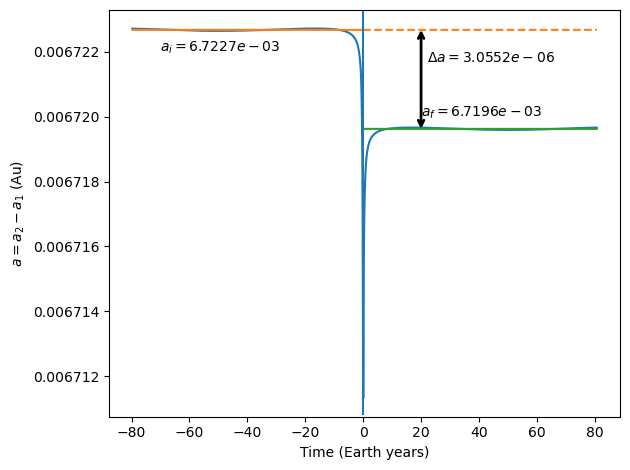

In [23]:
Nout = 20000
tmin = -0.805*tconj 
tmax = 0.815*tconj  
correction, phi_err = calculate_phi_correction(phi, etilde, tmin, tmax, Nout, iterations=2)
sim = setup(t0=tmin, correction=correction)
ps = sim.particles


da, dl, phi_arr = np.zeros(Nout), np.zeros(Nout), np.zeros(Nout)
times = np.linspace(tmin, tmax, Nout)
for i, time in enumerate(times):
    sim.integrate(time)
    da[i] = ps[2].a - ps[1].a
    dl[i] = unwrap_l(ps) 
    phi_arr[i] = ps[2].l - ps[2].pomega
    
# conjunction index, angle at conjunction
conj_idx = np.argmin(np.abs(dl))
_, da0_plot, daf_plot = calc_Delta_a(da, conj_idx)

# plot da throughout encounter
fig, ax = plt.subplots()
ax.plot(times, da)
t_before_conj = times[:conj_idx]
t_after_conj = times[conj_idx:]
ax.plot(t_before_conj, np.ones_like(t_before_conj)*da0_plot, label='pre-conjunction')
ax.plot(t_after_conj, np.ones_like(t_after_conj)*da0_plot, c='C1', linestyle='--')
ax.plot(t_after_conj, np.ones_like(t_after_conj)*daf_plot, label='post-conjunction')
ax.axvline(times[conj_idx], da[conj_idx]) # conjunction location
ax.annotate('$a_i={:.4e}$'.format(da0_plot), (-70, .006722))
ax.annotate('$a_f={:.4e}$'.format(daf_plot), (20, .006720))
ax.annotate("", (20, da0_plot), (20, daf_plot), arrowprops={'arrowstyle':'<->','shrinkA':0, 'shrinkB':0,'linewidth':2, 'color':'black'})
ax.annotate('$\Delta a={:.4e}$'.format(da0_plot-daf_plot), (22, .0067217))
ax.set(xlabel='Time (Earth years)', ylabel='$a = a_2 - a_1$ (Au)') #title='Evolution of Relative Semimajor Axis during Conjunction')
#ax.legend()
fig.tight_layout()
fig.savefig('delta_a.pdf')

We repeat this process for a range of initial eccentricity values for the test particle's orbit and compare the numerical simulation result to Namoni's result.

In [24]:
Nout = 100000 # num time steps in integration
N = 10 #
etilde_list = np.linspace(0.001, .2, N)
a_kicks, paper_1, paper_2, paper_3, paper_4 = np.zeros(N), np.zeros(N), np.zeros(N), np.zeros(N), np.zeros(N)
for idx, etilde in enumerate(etilde_list):
    #setup
    e = etilde*ec
    correction, phi_err = calculate_phi_correction(phi, etilde, tmin, tmax, Nout, iterations=2)
    sim = setup(t0=tmin, correction=correction, etilde=etilde)
    ps = sim.particles

    # integration
    da, dl, phi_arr = np.zeros(Nout), np.zeros(Nout), np.zeros(Nout)
    times = np.linspace(tmin, tmax, Nout)
    for i, time in enumerate(times):
        sim.integrate(time)
        da[i] = ps[2].a - ps[1].a
        dl[i] = unwrap_l(ps) # removes 2*pi jumps in dl
        phi_arr[i] = ps[2].l - ps[2].pomega
    
    # conjunction index, angle at conjunction
    conj_idx = np.argmin(np.abs(dl))

    theta = phi_arr[conj_idx] # angle at conjunction

    # n-body solution
    Delta_a, da0, daf = calc_Delta_a(da, conj_idx)
    
    #delta_a = daf - da0
    a_kicks[idx] = Delta_a / ps[1].a

    # Namouni solution
    paper_1[idx] = -8/9 * mutot / ec**2 * (etilde*np.sin(theta)*W1) # 1st order approx
    paper_2[idx] = -8/9 * mutot / ec**2 * (etilde*np.sin(theta)*W1 + 2*etilde**2*np.sin(2*theta)*W2) # 2nd order approx
    paper_3[idx] = -8/9 * mutot / ec**2 * (etilde*np.sin(theta)*W1 + 2*etilde**2*np.sin(2*theta)*W2 + 3*W3*etilde**3*np.sin(3*theta)) # 3rd order approx
    paper_4[idx] = -8/9 * mutot / ec**2 * (etilde*np.sin(theta)*W1 + 2*etilde**2*np.sin(2*theta)*W2 + 3*W3*etilde**3*np.sin(3*theta) + 4*W4*etilde**4*np.sin(4*theta)) # 4th order approx

Hill radius separation: 13.445441364248184
Hill radius separation: 13.44544136424774
Hill radius separation: 13.445441364250405
Hill radius separation: 13.445441364248184
Hill radius separation: 13.445441364249517
Hill radius separation: 13.445441364248628
Hill radius separation: 13.445441364248184
Hill radius separation: 13.445441364248184
Hill radius separation: 13.445441364249072
Hill radius separation: 13.445441364248628


Comparison of results from Namouni and n-body simulation:

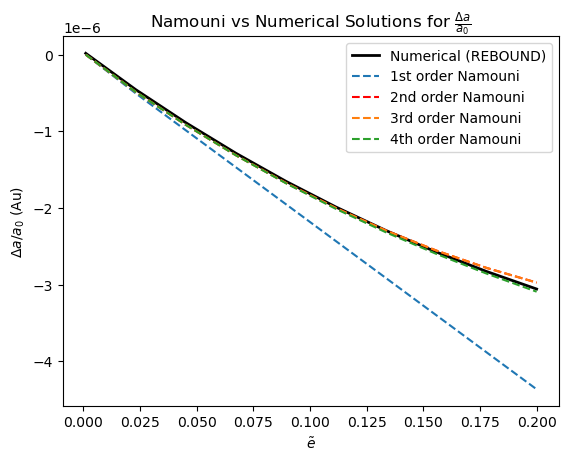

In [25]:
fig, ax = plt.subplots()
ax.plot(etilde_list, a_kicks, 'k-', linewidth=2, label='Numerical (REBOUND)')
ax.plot(etilde_list, paper_1, '--', label='1st order Namouni')
ax.plot(etilde_list, paper_2, '--', label='2nd order Namouni', c='red')
ax.plot(etilde_list, paper_3, '--', label='3rd order Namouni')
ax.plot(etilde_list, paper_4, '--', label='4th order Namouni')
ax.set(xlabel="$\\tilde{e}$", ylabel='$\Delta a$/$a_0$ (Au)', title='Namouni vs Numerical Solutions for $\\frac{\Delta a}{a_0}$')

ax.legend()
#fig.savefig('comp_plot.pdf') # pdf
fig.savefig('comp_plot.png', dpi=300) # png
